In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [20]:
def load_dataset():
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'validation': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Todo: Load dataset
    dataset_path = '../../train_images'
    train_dataset = ImageFolder(root=dataset_path + "/train", transform=data_transforms['train'])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

    validation_dataset = ImageFolder(root=dataset_path + "/validation", transform=data_transforms['validation'])
    validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, num_workers=2)

    classes = ("1", "2", "3", "4")
    return train_dataset, train_loader, validation_dataset, validation_loader, classes

In [21]:
def train(model, train_loader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

In [22]:
def validation(model, validation_loader, criterion, device):
    validation_loss = 0.0
    validation_total = 0
    validation_correct = 0

    model.eval()

    with torch.no_grad():
        
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            validation_total += labels.size(0)
            validation_correct += (predicted == labels).sum().item()
    
    validation_loss = validation_loss / len(validation_loader.dataset)
    validation_accuracy = 100.0 * validation_correct / validation_total

    return validation_loss, validation_accuracy

In [23]:
def train_epochs(model, train_loader, validation_loader, criterion, optimizer, device, num_epochs, save_intervalidation=5):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    classes = ("1", "2", "3", "4")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validation(model, validation_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'validation Loss: {validation_loss:.4f} - validation Accuracy: {validation_accuracy:.2f}%')
        print()

        if (epoch + 1) % save_intervalidation == 0:
          # Save the model and variables
          torch.save(model.state_dict(), f'resnet50_run2_stage_{epoch+1}.pth')
          checkpoint = {
              'epoch': epoch + 1,
              'train_losses': train_losses,
              'train_accuracies': train_accuracies,
              'validation_losses': validation_losses,
              'validation_accuracies': validation_accuracies,
              'classes': classes,
          }
          torch.save(checkpoint, f'resnet50_stage_run2_variables_{epoch+1}.pth')

    return model, train_losses, train_accuracies, validation_losses, validation_accuracies

In [24]:
def plot_loss(train_losses, validation_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(validation_losses)), validation_losses, label='validationidation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()


In [25]:
def plot_accuracy(train_accuracies, validation_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(validation_accuracies)), validation_accuracies, label='validationidation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

In [26]:
def plot_image(dataset, model, classes):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    #model.to(device)  # Move the model to the GPU
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

cuda
Epoch 1/40
Train Loss: 1.3406 - Train Accuracy: 36.76%
validation Loss: 1.3058 - validation Accuracy: 44.01%

Epoch 2/40
Train Loss: 1.2301 - Train Accuracy: 44.59%
validation Loss: 1.2000 - validation Accuracy: 45.42%

Epoch 3/40
Train Loss: 1.1511 - Train Accuracy: 49.18%
validation Loss: 1.0993 - validation Accuracy: 51.58%

Epoch 4/40
Train Loss: 1.0986 - Train Accuracy: 51.24%
validation Loss: 1.0648 - validation Accuracy: 53.15%

Epoch 5/40
Train Loss: 1.0702 - Train Accuracy: 52.94%
validation Loss: 1.0627 - validation Accuracy: 53.82%

Epoch 6/40
Train Loss: 1.0485 - Train Accuracy: 53.50%
validation Loss: 1.0628 - validation Accuracy: 53.82%

Epoch 7/40
Train Loss: 1.0327 - Train Accuracy: 54.56%
validation Loss: 1.0554 - validation Accuracy: 53.95%

Epoch 8/40
Train Loss: 1.0152 - Train Accuracy: 56.09%
validation Loss: 1.0698 - validation Accuracy: 52.89%

Epoch 9/40
Train Loss: 0.9990 - Train Accuracy: 56.70%
validation Loss: 1.0748 - validation Accuracy: 53.24%

Epoch

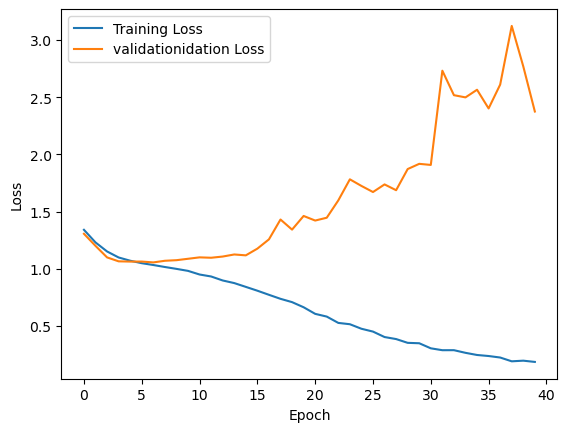

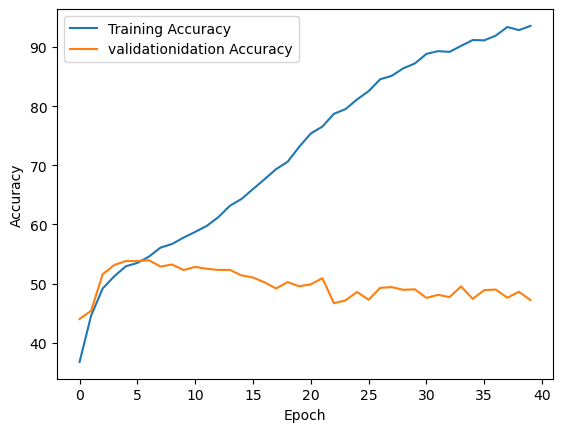

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


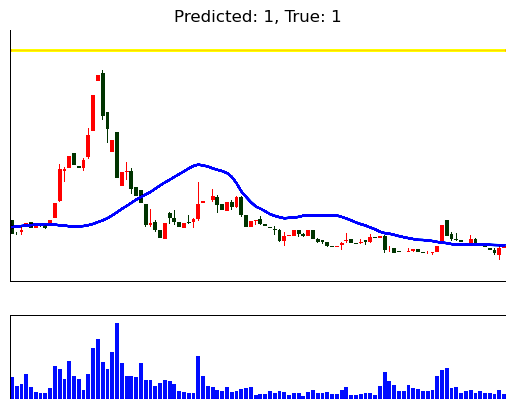

Predicted label:  1
Actual label:  1


In [27]:
# Flag to control whether to run training or use saved fine-tuned model.
train_model = True

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Number of classes
num_classes = 4

# Import ResNet50 model pretrained on ImageNet
# model = models.resnet50(weights=None)
model = models.alexnet()
# print("Network before modifying conv1:")
# print(model)

# #Modify conv1 to suit CIFAR-10
# model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the final fully connected layer according to the number of classes

for params in model.parameters():
  params.requires_grad = True
n_features = model.classifier[6].in_features
fc = torch.nn.Linear(n_features, 4)
model.classifier[6] = fc
# model.classifier[1] = nn.Linear(in_features=1000, out_features=num_classes)

# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)
# print("Network after modifying conv1:")
# print(model)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Load the dataset
# trainset, train_loader, validation_dataset, validation_loader, classes = load_dataset()
validation_dataset, validation_loader,trainset, train_loader, classes = load_dataset()

if train_model:
  # Train the model for 20 epochs, saving every 5 epochs
  num_epochs = 40
  save_intervalidation = 5
  model, train_losses, train_accuracies, validation_losses, validation_accuracies = train_epochs(
      model, train_loader, validation_loader, criterion, optimizer, device,
      num_epochs, save_intervalidation)

  # Save the final trained model
  # torch.save(model.state_dict(), f'resnet50_stage_final_model_epochs_{num_epochs}.pth')

  # Plot and save the loss and accuracy plots
  plot_loss(train_losses, validation_losses)
  plot_accuracy(train_accuracies, validation_accuracies)
else:
  # Load the pre-trained model
  model.load_state_dict(torch.load('resnet50_stage_final_model_epochs_50.pth'))
  
  # Load the variables
  checkpoint = torch.load("resnet50_stage_variables.pth")
  epoch = checkpoint['epoch']
  train_losses = checkpoint['train_losses']
  train_accuracies = checkpoint['train_accuracies']
  validation_losses = checkpoint['validation_losses']
  validation_accuracies = checkpoint['validation_accuracies']
  classes = checkpoint['classes']
  model.to(device)
  model.eval()

# Plot and save an example image
plot_image(validation_dataset, model, classes)

In [28]:
torch.save(model.state_dict(), f'resnet50_stage_final_model_epochs_{num_epochs}.pth')